# Extreme-Correction applied to Hs and Tp

Extreme correction technique applied to Hs and Tp from Santoña.

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

os.chdir(r"c:\Users\user\Victor\Trabajo\ExtremeCorrection")
from src.extr_corr import ExtremeCorrection

# Load Data

In [2]:
historical_dataset = xr.open_dataset("Data/DatosJared/Wave_families_santona_daily.nc")
sampled_dataset = xr.open_dataset("Data/DatosJared/simulated_waves.nc").rename({"bulk_Hs": "Hs", "bulk_Tp": "Tp", "bulk_Dir": "Dir"})

In [3]:
historical_dataset

<xarray.Dataset>
Dimensions:      (time: 14610)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    sea_Hs       (time) float32 ...
    sea_Tp       (time) float32 ...
    sea_Dir      (time) float32 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    Hs           (time) float32 ...
    Tp           (time) float32 ...
    Dir          (time) float32 ...
    bmus         (time) int64 ...

In [4]:
sampled_dataset

<xarray.Dataset>
Dimensions:  (n_sim: 1, time: 36891)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    DWT      (n_sim, time) int64 ...
    Hs       (n_sim, time) float64 ...
    Tp       (n_sim, time) float64 ...
    Dir      (n_sim, time) float64 ...

Asumo que bmus tiene los WT, sino habria que cogerlos de la siguiente forma:

In [5]:
df_hist = historical_dataset.to_dataframe().loc[:,["Hs", "Tp", "Dir"]]
df_hist["yyyy"] = df_hist.index.year
df_hist["mm"] = df_hist.index.month
df_hist["dd"] = df_hist.index.day
df_hist = df_hist.reset_index()
df_hist["time"] = df_hist.index / 365.25
df_hist.head()

,time,Hs,Tp,Dir,yyyy,mm,dd
0,0.000000,1.023583,4.836266,185.625000,1979,1,1
1,0.002738,1.341333,5.067072,89.291664,1979,1,2
2,0.005476,1.855333,6.305674,126.416664,1979,1,3
3,0.008214,4.830250,11.519656,282.291656,1979,1,4
4,0.010951,2.902167,11.920074,305.916656,1979,1,5


In [6]:
df_sim = sampled_dataset.sel(n_sim=0).to_dataframe().loc[:,["Hs", "Tp", "Dir"]]
df_sim["yyyy"] = df_sim.index.year
df_sim["mm"] = df_sim.index.month
df_sim["dd"] = df_sim.index.day
df_sim = df_sim.reset_index()
df_sim["time"] = df_sim.index / 365.25
df_sim.head()

,time,Hs,Tp,Dir,yyyy,mm,dd
0,0.000000,1.750975,8.529534,283.245014,1999,1,1
1,0.002738,1.627966,8.854106,299.305291,1999,1,2
2,0.005476,2.761744,9.576388,329.714930,1999,1,3
3,0.008214,2.325261,14.954787,306.216905,1999,1,4
4,0.010951,1.819668,16.823529,288.421431,1999,1,5


# Hs

Init threshold of quantile 0.98

In [7]:
np.quantile(df_hist["Hs"], 0.98)

5.4903304195404035

In case we want to use the minimum AM value of $H_s$ as init threshold

In [8]:
df_hist.groupby(["yyyy"])["Hs"].max().min()

5.910250186920166

In [9]:
config = {
    'var': "Hs",
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.242,
    'folder': 'Figures/Santona/Hs_Santona_Hs'
}

pot_config = {
    'n0': 10,
    'min_peak_distance': 2,
    'init_threshold': np.quantile(df_hist["Hs"], 0.98),
    'siglevel': 0.01,
    'plot_flag': True
}

extr_corr_complete = ExtremeCorrection(
    data_hist = df_hist,
    data_sim = df_sim[:-1],
    config=config,
    pot_config=pot_config,
    method="POT",
    conf_level=0.95,
    random_state=0
)

Poisson parameters difference: 3.541315765073997


In [10]:
extr_corr_complete.opt_threshold

5.491500377655029

In [11]:
ecdf_hist_hs = ECDF(df_hist["Hs"])
ecdf_hist_hs(extr_corr_complete.opt_threshold)

0.9800136892539356

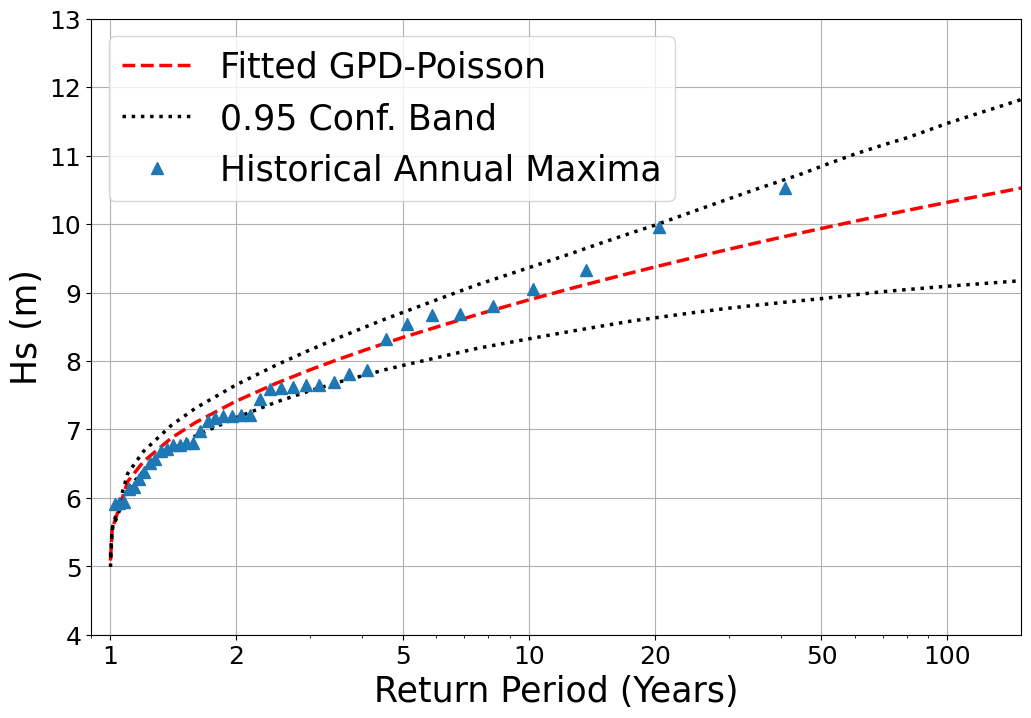

In [12]:
extr_corr_complete.apply_correction(fit_diag=True)
fig, ax = extr_corr_complete.return_period_plot(conf_int_method="bootstrap")
ax.set_ylim(4, 13)
ax.set_xlim(0.9,150)
ax.set_ylabel("Hs (m)", fontsize=25)
ax.set_xlabel("Return Period (Years)", fontsize=25)
ax.legend(loc = "upper left", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_Historical_ReturnPeriod_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
extr_corr_complete.test_dist()

{'Statistic': 30.70721752015155, 'P-value': 8.664104766964442e-09}

In [14]:
def q_gev(prob, p):
    """
    Quantile function of GEV
    """
    xi = p[2]
    mu = p[0]
    sigma = p[1]

    if np.abs(xi) < 1e-8:
        return mu - sigma * np.log(-np.log(prob))
    else:
        return mu + (sigma/xi)*((-np.log(prob))**(-xi)-1)

In [15]:
# from src.gev_utils import q_gev
from scipy.stats import genextreme
from scipy import stats

Bootstrap_test = 2000
# Historical parameters estimated
u, sigma, xi = extr_corr_complete.parameters
mu = u + sigma/xi * (extr_corr_complete.poiss_parameter ** xi - 1)
psi = sigma * extr_corr_complete.poiss_parameter ** xi


CvM_statistic = 1/(12*extr_corr_complete.n_sim_year_peaks) + np.sum((np.sort(genextreme.cdf(extr_corr_complete.sim_max_data, c=-xi, loc=mu, scale=psi)) - (2*np.arange(1, extr_corr_complete.n_sim_year_peaks +1) - 1)/(2*extr_corr_complete.n_sim_year_peaks))**2)



# Bootstrap calibration
boot_statistic = np.zeros(Bootstrap_test)

for b in range(Bootstrap_test):
    # 1. Simulate AM of size n_hist from GEV with historical parameters
    uniform_random_hist = np.random.uniform(size=extr_corr_complete.n_year_peaks)
    simulated_am_boot_hist = q_gev(uniform_random_hist, [mu, psi, xi])

    # 2. Fit GEV to simulated AM
    xi_bootfit, mu_bootfit, psi_bootfit = genextreme.fit(simulated_am_boot_hist) # Note xi_bootfit is -xi

    # 3. Simulate AM of size n_sim from GEV with historical parameters
    uniform_random_sim = np.random.uniform(size=extr_corr_complete.n_sim_year_peaks)
    simulated_am_boot_sim = genextreme.ppf(uniform_random_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 4. Compute bootstrap synthetic AM values using the bootfit
    u_bootfit = genextreme.cdf(simulated_am_boot_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 5. Compute CvM test for the bootstrap sample
    boot_statistic[b] = 1/(12*extr_corr_complete.n_sim_year_peaks) + np.sum((np.sort(u_bootfit) - (2*np.arange(1, extr_corr_complete.n_sim_year_peaks + 1) - 1)/(2*extr_corr_complete.n_sim_year_peaks))**2)

bootstrap_p_value = (1 + np.sum(boot_statistic >= CvM_statistic)) / (1 + Bootstrap_test)
print(f"Bootstrap p-value of CvM test {bootstrap_p_value}")

Bootstrap p-value of CvM test 0.0004997501249375312


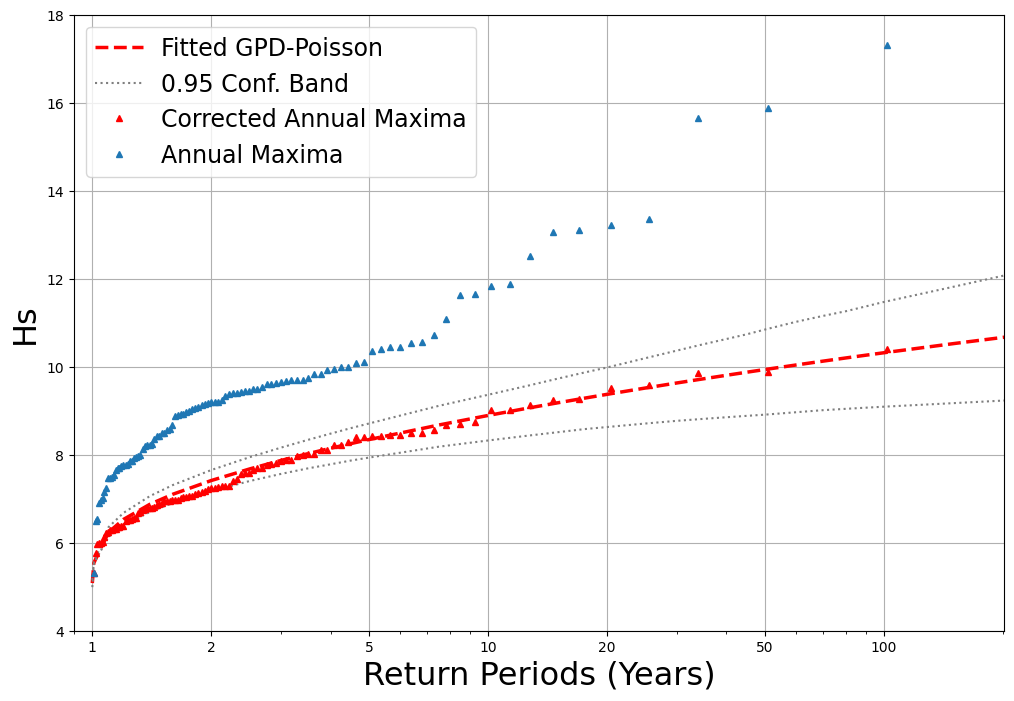

In [16]:
extr_corr_complete.apply_sim_correction()
fig, ax = extr_corr_complete.sim_return_period_plot(show_corrected=True, show_uncorrected=True)
# extr_corr_complete.sim_return_period_plot(show_corrected=True, show_uncorrected=False)
# extr_corr_complete.sim_return_period_plot(show_corrected=False, show_uncorrected=True)

ax.set_ylim(4, 18)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_Simulation_ReturnPeriod_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
extr_corr_complete.poiss_parameter

4.824894318959617

In [18]:
extr_corr_complete.time_interval_hist

40.000876131441615

In [19]:
extr_corr_complete.n_pit / 362.242

40.332153643144636

In [20]:
extr_corr_complete.n_pot / (extr_corr_complete.n_pit / 362.242)

4.78526392881588

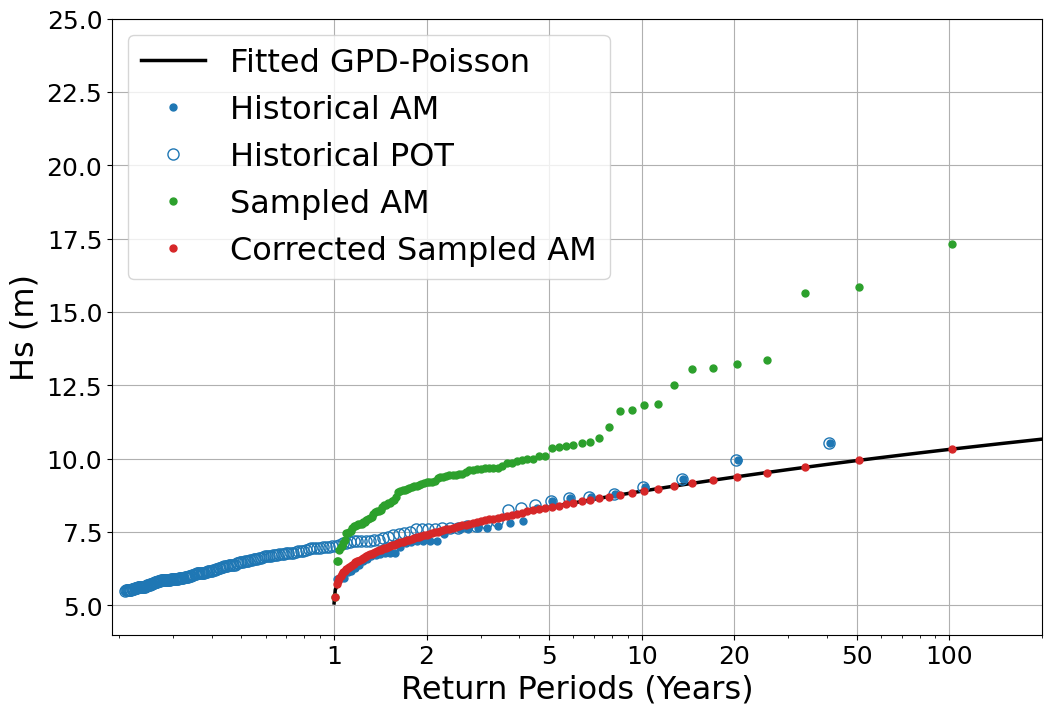

In [26]:

### Plot
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# # Fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, np.sort(extr_corr_complete.x_vals_gpd_poiss_hist), color = 'black', linewidth=2.5, label='Fitted GPD-Poisson')
# # Confidence interval for fitted GPD-Poisson
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "tab:gray",linestyle='dotted', label=f'{extr_corr_complete.conf} Conf. Band')
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "tab:gray",linestyle='dotted')



# Historical data
ax.semilogx(extr_corr_complete.T_annmax, extr_corr_complete.max_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=5, label='Historical AM')
# T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.poiss_parameter)
T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.n_pot / (extr_corr_complete.n_pit / 362.242))
ax.semilogx(T_hist_pot, np.sort(extr_corr_complete.pot_data), color="tab:blue", linewidth=0, marker='o',markersize=8, fillstyle='none', label='Historical POT')



# No corrected data
# ax.semilogx(T_pt_corrected_sim, self.sim_pit_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Daily Data')
# ax.semilogx(T_pot_sim, self.sim_pot_data_sorted, color="orange", linewidth=0, marker='o',markersize=5, label='POT')
# ax.semilogx(T_pot, extr_corr_complete.sim_pot_data_sorted, label="Sampled POT", color="tab:green", linewidth=0, marker='o',markersize=5)

# ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_sorted[extr_corr_complete.am_index_0:], color="tab:green", linewidth=0, marker='o',markersize=5, label='Sampled AM')
ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_sorted, color="tab:green", linewidth=0, marker='o',markersize=5, label='Sampled AM')



ecdf_pot = np.arange(1, extr_corr_complete.n_pot_sim + 1) / (extr_corr_complete.n_pot_sim + 1)
T_pot = 1 / (1-ecdf_pot) / extr_corr_complete.poiss_parameter
# Corrected data 
    # ax.semilogx(T_pt_corrected_sim, np.sort(self.sim_pit_data_corrected), linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Corrected Daily Data')
    # ax.semilogx(T_ev_corrected_sim, stats.genpareto.ppf(self.runif_pot_probs_sim, self.parameters[2], loc=self.parameters[0], scale=self.parameters[1]), 
    #             color = 'orange',linewidth=0, marker='o',markersize=5, label=f'Corrected POT')
    # ax.semilogx(self.T_annmax_sim, q_pot(self.ecdf_annmax_probs_sim, self.opt_threshold, self.poiss_parameter, self.gpd_parameters[1], self.gpd_parameters[2]), color = 'red',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
# ax.semilogx(T_pot, np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_pot_data_locs]), label="Corrected Sampled POT", color="tab:red", linewidth=0, marker='o',markersize=5)
# ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_corrected_sorted[extr_corr_complete.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')

from src.pot_utils import q_pot

sim_max_data_corrected = np.zeros(extr_corr_complete.n_sim_year_peaks)
ecdf_max_probs_sim = np.arange(1, extr_corr_complete.n_sim_year_peaks + 1) / (extr_corr_complete.n_sim_year_peaks + 1)   # ECDF
for i in range(extr_corr_complete.am_index_0):
    sim_max_data_corrected[i] = extr_corr_complete.sim_max_data_sorted[i]
    
sim_max_data_corrected[extr_corr_complete.am_index_0:] = q_pot(ecdf_max_probs_sim[extr_corr_complete.am_index_0:], extr_corr_complete.parameters, extr_corr_complete.poiss_parameter)    # Corrected POT
if extr_corr_complete.n_sim_year_peaks > 1:
    sim_aux_pit_corrected = np.interp(
                    extr_corr_complete.sim_pit_data,              # x-coords to interpolate
                    np.append(min(extr_corr_complete.sim_pit_data), extr_corr_complete.sim_max_data_sorted),    # x-coords of data points
                    np.append(min(extr_corr_complete.sim_pit_data), sim_max_data_corrected)  # y-coords of data points 
                )
    sim_pit_data_corrected = sim_aux_pit_corrected
    sim_max_data_corrected_sorted = np.sort(sim_max_data_corrected)

# ax.semilogx(extr_corr_complete.T_annmax_sim, sim_max_data_corrected_sorted[extr_corr_complete.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')
ax.semilogx(extr_corr_complete.T_annmax_sim, sim_max_data_corrected_sorted, color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')



ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete.var} (m)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())   
# ax.set_xlim(right=10000)
ax.set_xlim(left=0.19, right=200)
# ax.set_ylim(bottom=0)
ax.set_ylim(bottom=4, top=25)
ax.legend(loc='upper left', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.grid()

plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_HistPOTAM_Deterministic.png", dpi=300, bbox_inches="tight")
plt.show()

In [27]:
extr_corr_complete.parameters

[5.491500377655029, 1.1128642407260836, -0.12203866981894917]

In [28]:
extr_corr_complete.poiss_parameter, extr_corr_complete.sim_poiss_parameter

(4.824894318959617, 8.366210084033614)

In [29]:
extr_corr_complete.sim_poiss_parameter/extr_corr_complete.poiss_parameter

1.733967529849981

## Loop over correction

In [30]:
dict_maximos_corregidos_Hs = {}
dict_sim_pit_corrected_Hs = {}

for i in range(100):
    
    extr_corr_complete.apply_sim_correction(random_state=i)   # Apply the correction in the simulated data
    # if i == 0:
    #     extr_corr.sim_return_period_plot(show_corrected=True, show_uncorrected=True)                        # Default to plot the corrected and no corrected data
    #     fitted_gev = extr_corr.
    
    
    dict_maximos_corregidos_Hs[i] = extr_corr_complete.sim_max_data_corrected_sorted
    dict_sim_pit_corrected_Hs[i] = extr_corr_complete.sim_pit_data_corrected

In [31]:
dict_maximos_corregidos_Hs[0]

array([ 5.30125817,  5.7047568 ,  5.72343224,  5.72495947,  5.92426384,
        6.07382926,  6.09745625,  6.13668365,  6.21938114,  6.2514017 ,
        6.2612391 ,  6.26576394,  6.2876546 ,  6.32311583,  6.35528231,
        6.35708897,  6.36291555,  6.39671878,  6.40754913,  6.43116261,
        6.44984175,  6.5041381 ,  6.512026  ,  6.58314161,  6.62462635,
        6.66158021,  6.66603884,  6.7635172 ,  6.7880094 ,  6.81868628,
        6.82093913,  6.86747902,  6.88487669,  6.90251124,  6.9524333 ,
        6.95898749,  6.96048849,  7.06406265,  7.07457839,  7.08710377,
        7.12375415,  7.20019553,  7.20118377,  7.22346174,  7.25662389,
        7.25800144,  7.26051815,  7.30413494,  7.31741552,  7.32947385,
        7.33532182,  7.46989559,  7.47349117,  7.48803185,  7.52953163,
        7.5398141 ,  7.58679537,  7.59064093,  7.59167949,  7.59638615,
        7.61179525,  7.64035389,  7.68493663,  7.69071118,  7.71093603,
        7.72453765,  7.72651694,  7.79040941,  7.80789198,  7.82

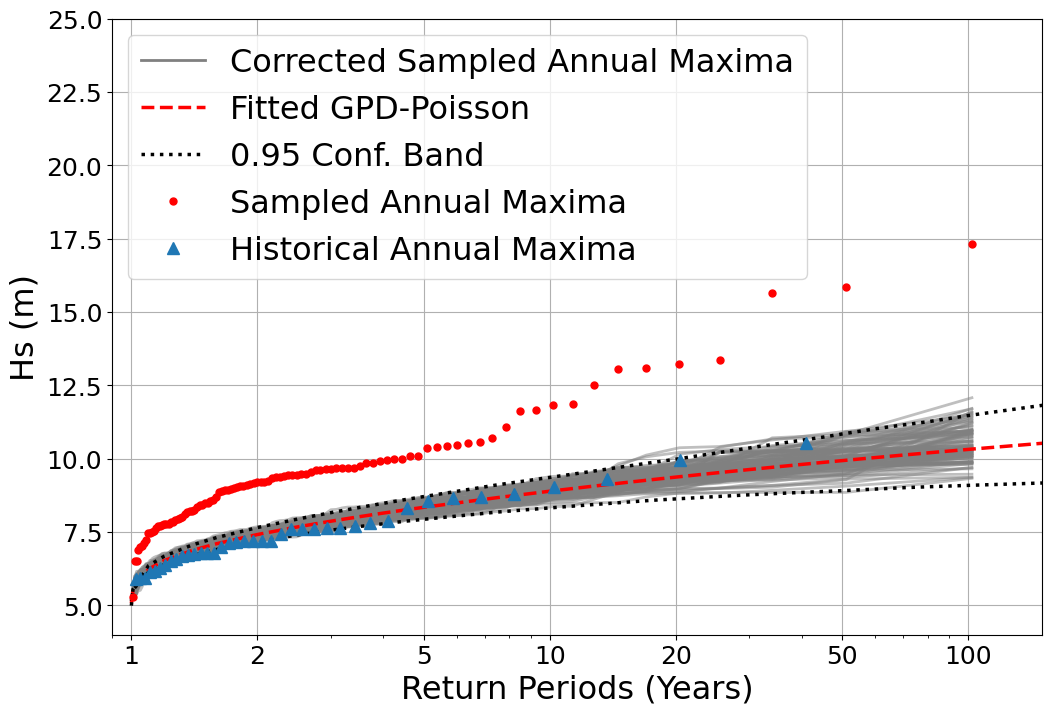

In [32]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# Corrected AM
ax.semilogx(extr_corr_complete.T_annmax_sim, dict_maximos_corregidos_Hs[0], color = 'gray', linewidth=2, alpha=0.5,label='Corrected Sampled Annual Maxima')
for i in range(1,100):
    ax.semilogx(extr_corr_complete.T_annmax_sim, dict_maximos_corregidos_Hs[i], color = 'gray', linewidth=2, alpha=0.5)

# Fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.x_vals_gpd_poiss_sim, color = 'red',linestyle='dashed', linewidth=2.5, label='Fitted GPD-Poisson')
# Confidence interval for fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "black",linestyle='dotted', linewidth=2.5, label=f'{extr_corr_complete.conf} Conf. Band')
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "black",linestyle='dotted', linewidth=2.5)


ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_sorted, color="red", linewidth=0, marker='o',markersize=5, label='Sampled Annual Maxima')

ax.semilogx(extr_corr_complete.T_annmax, extr_corr_complete.max_data_sorted, color="tab:blue", linewidth=0, marker='^',markersize=8, label='Historical Annual Maxima')

ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete.var} (m)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
# ax.set_xticklabels([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000], fontsize=15)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
# ax.set_yticklabels(ax.set, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_xlim(0.9,150)
ax.set_ylim(bottom=4, top=25)
leg = ax.legend(loc='upper left', ncol=1, fontsize=23)
for lh in leg.legend_handles:
    lh.set_alpha(1)
# ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_ReturnLevel_Simulated_Ensemble_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [33]:
correlation_hs = extr_corr_complete.correlation()
correlation_hs

{'Spearman': 0.9999999999999998, 'Kendall': 1.0, 'Pearson': 0.9924649528494015}

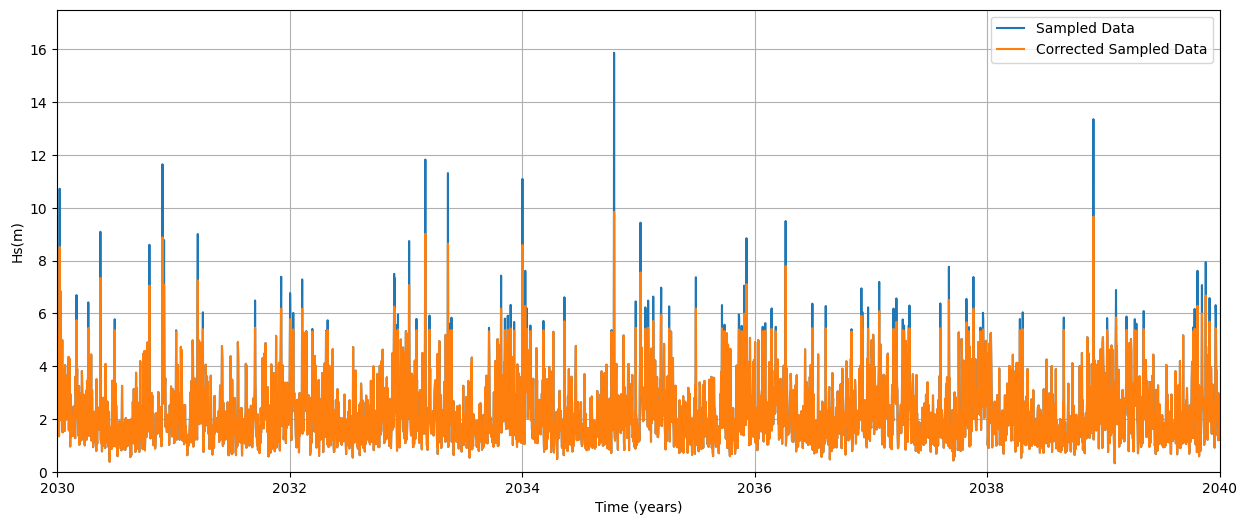

In [34]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete.sim_pit_data, label="Sampled Data", color="tab:blue")
ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete.sim_pit_data_corrected, label="Corrected Sampled Data", color="tab:orange")
# ax.hlines(5.25, xmin=2033, xmax=2035, color="black", linestyles="--")
ax.set_xlim(2030, 2040)
ax.set_ylim(0, 17.5)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Hs(m)")
ax.grid()
ax.legend()
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_SimTimeSeries_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Poisson parameter change 

In [35]:
sim_poiss_param_100_hs = np.zeros(100)
for i in range(100):
    sim_pot_corrected_hs, _, _ = extr_corr_complete.obtain_pots(
                dict_sim_pit_corrected_Hs[i],
                threshold=extr_corr_complete.opt_threshold,
                n0 = extr_corr_complete.pot_config['n0'],
                min_peak_distance=extr_corr_complete.pot_config['min_peak_distance'],
                siglevel = extr_corr_complete.pot_config['siglevel'],
                plot_flag = extr_corr_complete.pot_config['plot_flag'],
                optimize_threshold=False
            )
    sim_poiss_param_100_hs[i] = sim_pot_corrected_hs.size / extr_corr_complete.time_interval_sim

In [36]:
print(np.median(sim_poiss_param_100_hs), np.mean(sim_poiss_param_100_hs), np.std(sim_poiss_param_100_hs))

6.148421848739496 5.991988571428573 1.173813833822716


In [37]:
extr_corr_complete.sim_poiss_parameter

8.366210084033614

In [38]:
extr_corr_complete.poiss_parameter

4.824894318959617

In [39]:
np.quantile(sim_poiss_param_100_hs, [0.025, 0.975])

array([3.87444634, 7.60632059])

In [40]:
def poisson_rate_ci_garwood(k, T, conf=0.95):
    """
    IC exacto (Garwood) para la tasa lambda de un proceso Poisson,
    dado un conteo k observado en una exposición T.

    Retorna: (lambda_hat, lambda_low, lambda_high)
    """
    if T <= 0:
        raise ValueError("T debe ser > 0")
    if k < 0 or int(k) != k:
        raise ValueError("k debe ser un entero >= 0")

    alpha = 1 - conf
    lam_hat = k / T

    # Límite inferior: si k=0, el límite inferior es 0
    if k == 0:
        lam_low = 0.0
    else:
        lam_low = 0.5 * stats.chi2.ppf(alpha / 2, df=2 * k) / T

    # Límite superior
    lam_high = 0.5 * stats.chi2.ppf(1 - alpha / 2, df=2 * (k + 1)) / T

    return lam_hat, lam_low, lam_high

In [41]:
wald_lb = extr_corr_complete.poiss_parameter - 1.96 * np.sqrt(extr_corr_complete.poiss_parameter / extr_corr_complete.time_interval_hist)
wald_ub = extr_corr_complete.poiss_parameter + 1.96 * np.sqrt(extr_corr_complete.poiss_parameter / extr_corr_complete.time_interval_hist)

In [42]:
poiss_hist, poiss_hist_lb, poiss_hist_ub = poisson_rate_ci_garwood(extr_corr_complete.n_pot, extr_corr_complete.time_interval_hist, conf=0.95)
print(f"{np.mean((sim_poiss_param_100_hs >= poiss_hist_lb) & (sim_poiss_param_100_hs <= poiss_hist_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

20.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [43]:
poiss_hist_lb, poiss_hist_ub

(4.1681705726683775, 5.555718493555108)

In [44]:
wald_lb, wald_ub

(4.144179473368552, 5.505609164550683)

In [45]:
print(f"{np.mean((sim_poiss_param_100_hs >= wald_lb) & (sim_poiss_param_100_hs <= wald_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

23.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


Ver el número de datos diarios que hay entre cada bloque y como cambian los bloques

In [46]:
bloques = {}
for j in range(extr_corr_complete.sim_max_data_sorted.size):
    if j == 0:
        bloques[j] = (
            sum((extr_corr_complete.sim_pit_data >= min(extr_corr_complete.sim_pit_data)) & (extr_corr_complete.sim_pit_data < extr_corr_complete.sim_max_data_sorted[j])), 
            (min(extr_corr_complete.sim_pit_data), extr_corr_complete.sim_max_data_sorted[j]), 
            (min(extr_corr_complete.sim_pit_data_corrected), extr_corr_complete.sim_max_data_corrected_sorted[j])
            )
    else:
        bloques[j] = (
            sum((extr_corr_complete.sim_pit_data >= extr_corr_complete.sim_max_data_sorted[j-1]) & (extr_corr_complete.sim_pit_data < extr_corr_complete.sim_max_data_sorted[j])), 
            (extr_corr_complete.sim_max_data_sorted[j-1], extr_corr_complete.sim_max_data_sorted[j]), 
            (extr_corr_complete.sim_max_data_corrected_sorted[j-1], extr_corr_complete.sim_max_data_corrected_sorted[j])
            )

In [47]:
bloques

{0: (35736,
  (0.17059068486300943, 5.301258173546213),
  (0.17059068486300943, 5.301258173546213)),
 1: (694,
  (5.301258173546213, 6.4973464443083495),
  (5.301258173546213, 5.4546383074685245)),
 2: (12,
  (6.4973464443083495, 6.528554942439624),
  (5.4546383074685245, 5.6579521391891205)),
 3: (117,
  (6.528554942439624, 6.901576514188907),
  (5.6579521391891205, 5.85430577430833)),
 4: (21,
  (6.901576514188907, 6.977285020826242),
  (5.85430577430833, 5.945237280226445)),
 5: (9,
  (6.977285020826242, 7.023372717237794),
  (5.945237280226445, 5.983034979752151)),
 6: (24,
  (7.023372717237794, 7.143926407312166),
  (5.983034979752151, 5.999080342789096)),
 7: (18,
  (7.143926407312166, 7.236446723128276),
  (5.999080342789096, 6.171833243720589)),
 8: (47,
  (7.236446723128276, 7.467809395689405),
  (6.171833243720589, 6.179226869072496)),
 9: (3,
  (7.467809395689405, 7.481819293345467),
  (6.179226869072496, 6.249896714679119)),
 10: (3,
  (7.481819293345467, 7.495418268629498)

In [48]:
df_hist.groupby("yyyy")["Hs"].max().min()


5.910250186920166

In [49]:
df_hist.groupby("yyyy")["Hs"].max()

yyyy
1979     7.868084
1980     7.646750
1981     6.384251
1982     9.049001
1983     6.767667
1984     7.693334
1985     6.275084
1986     8.672501
1987     6.125750
1988     8.807667
1989    10.525500
1990     9.963668
1991     6.679001
1992     5.910250
1993     7.603001
1994     7.211000
1995     6.975168
1996     7.646501
1997     6.568834
1998     6.799750
1999     7.197500
2000     9.321668
2001     6.161251
2002     6.514668
2003     7.128250
2004     5.927250
2005     6.711417
2006     7.202334
2007     7.811250
2008     6.797417
2009     8.542834
2010     8.693000
2011     7.446500
2012     5.933084
2013     6.769667
2014     8.321667
2015     7.593250
2016     7.169834
2017     7.612250
2018     7.206167
Name: Hs, dtype: float32

ACF and PACF

In [50]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

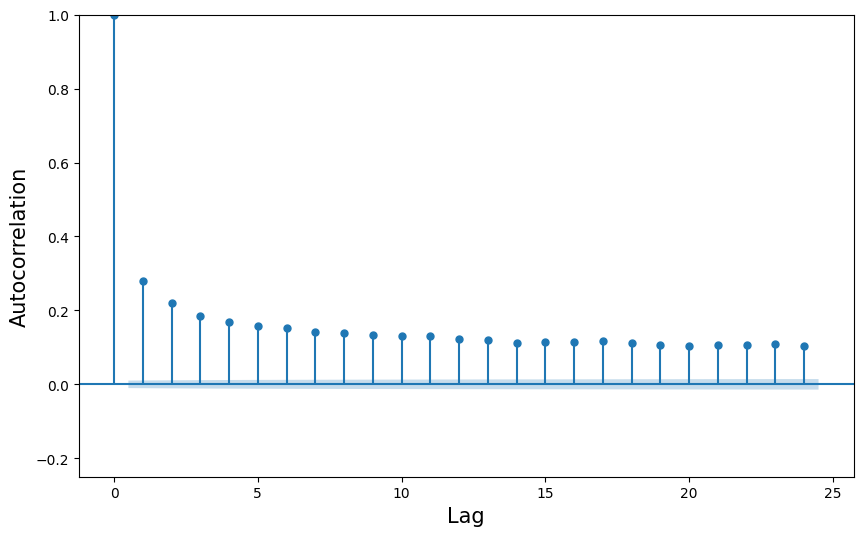

In [51]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_acf(extr_corr_complete.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_ACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [52]:
acf_hist, confint_hist = acf(extr_corr_complete.sim_pit_data, nlags=7, alpha=0.05)
acf_sim, confint_sim = acf(extr_corr_complete.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [53]:
import scipy.stats as stats
stats.pearsonr(acf_hist, acf_sim)

PearsonRResult(statistic=0.9999491518958213, pvalue=3.286606744964017e-13)

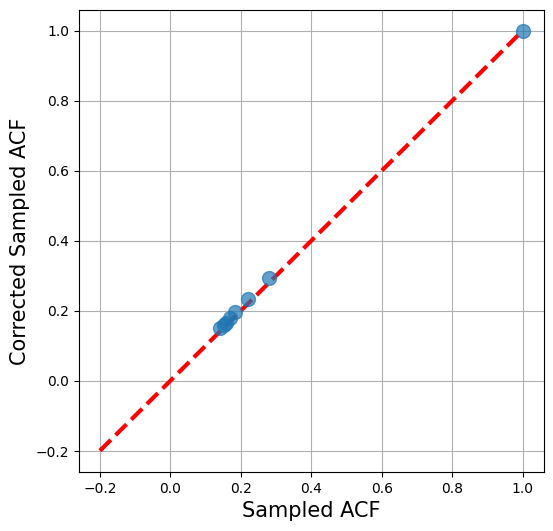

In [54]:
plt.figure(figsize=(6,6))
plt.plot([-0.2,1],[-0.2,1], 'r--', linewidth=3)
plt.plot(acf_hist, acf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled ACF", fontsize=15)
plt.ylabel("Corrected Sampled ACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_ACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

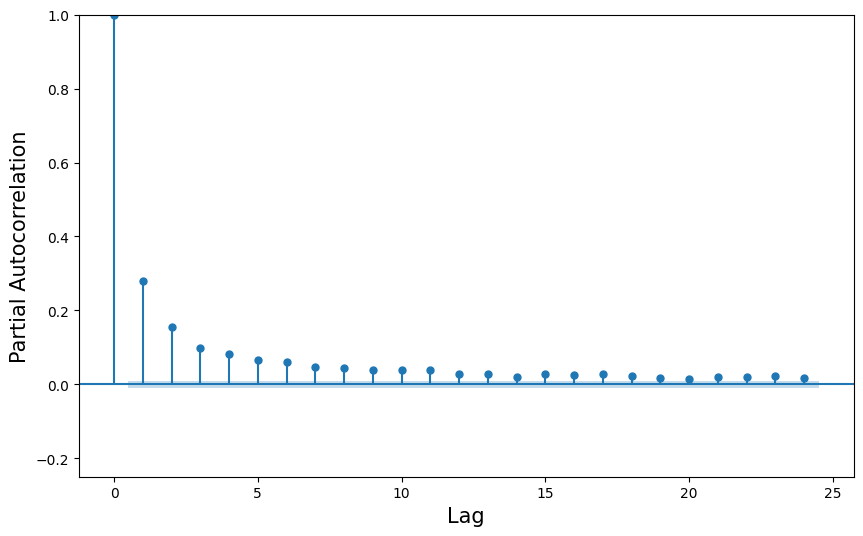

In [55]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_pacf(extr_corr_complete.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Partial Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_PACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [56]:
pacf_hist, pconfint_hist = pacf(extr_corr_complete.sim_pit_data, nlags=7, alpha=0.05)
pacf_sim, pconfint_sim = pacf(extr_corr_complete.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [57]:
stats.pearsonr(pacf_hist, pacf_sim)

PearsonRResult(statistic=0.9998788110962602, pvalue=4.449273519164029e-12)

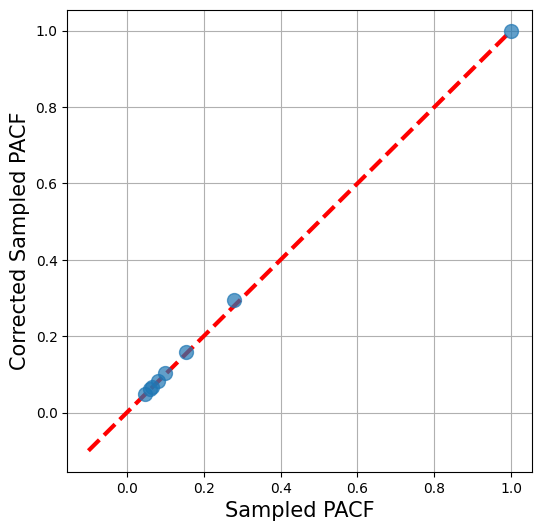

In [58]:
plt.figure(figsize=(6,6))
plt.plot([-0.1,1],[-0.1,1], 'r--', linewidth=3)
plt.plot(pacf_hist, pacf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled PACF", fontsize=15)
plt.ylabel("Corrected Sampled PACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_PACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

QQ-plot between quantiles 0.05 and 0.95 of the whole distribution

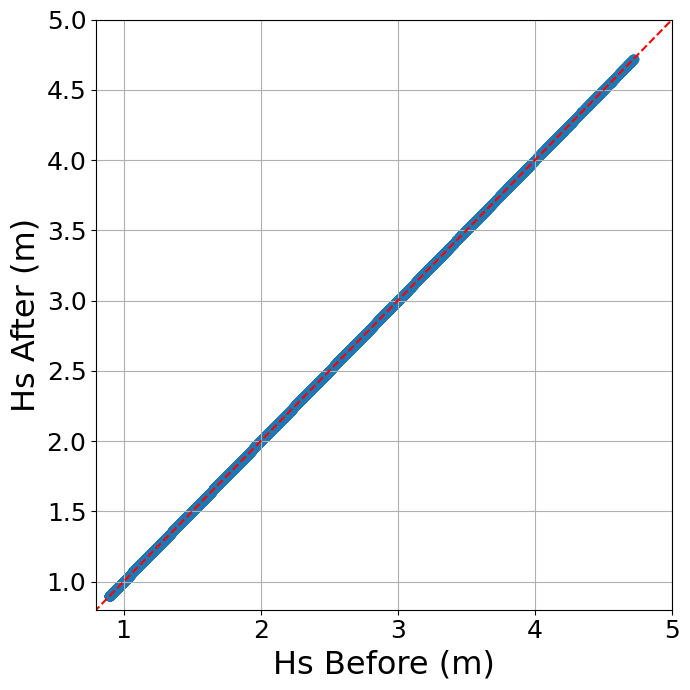

In [59]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
# QQ plot (top) before
probabilities_qq = (np.arange(1, extr_corr_complete.n_sim_pit + 1)) / (extr_corr_complete.n_sim_pit+1)
mask_probs = (probabilities_qq >= 0.05) & (probabilities_qq <= 0.95)

ax1.scatter(extr_corr_complete.sim_pit_data_sorted[mask_probs], np.sort(extr_corr_complete.sim_pit_data_corrected)[mask_probs], label="Data vs GPD", alpha=0.7)
ax1.plot([0,5], [0,5], 'r--', label="y = x (Reference)")
ax1.set_xlabel("Hs Before (m)", fontsize=23)
ax1.set_ylabel("Hs After (m)", fontsize=23)
ax1.grid()
ax1.set_xlim(0.8, 5)
ax1.set_ylim(0.8, 5)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.savefig(f"{extr_corr_complete.folder}/Hs_BeforeAfterCorr.png", dpi=300, bbox_inches='tight')
# plt.close(fig)

In [60]:
from scipy.stats import gaussian_kde

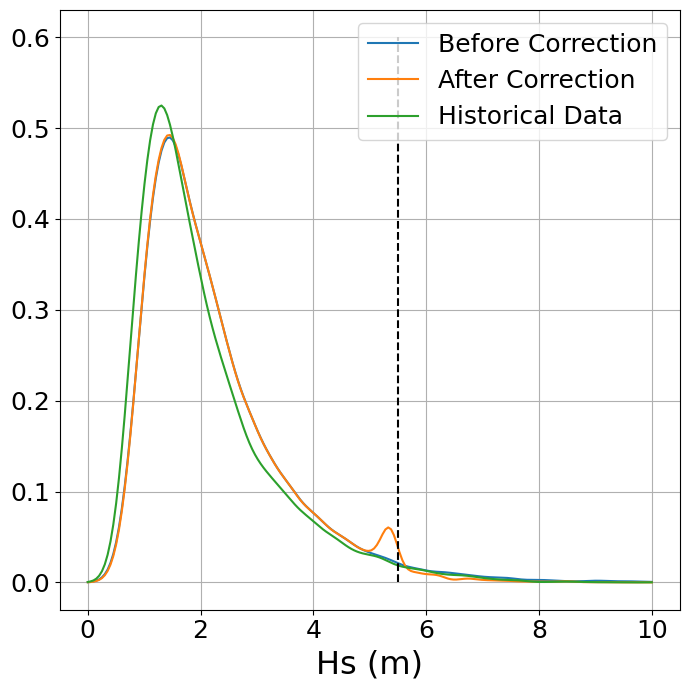

In [61]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

density_before = gaussian_kde(extr_corr_complete.sim_pit_data)
density_after = gaussian_kde(extr_corr_complete.sim_pit_data_corrected)
density_hist = gaussian_kde(df_hist["Hs"])

x_vals = np.linspace(0, 10, 200)
ax1.plot(x_vals, density_before(x_vals), label="Before Correction", color="tab:blue")
ax1.plot(x_vals, density_after(x_vals), label="After Correction", color="tab:orange")
ax1.plot(x_vals, density_hist(x_vals), label="Historical Data", color="tab:green")
ax1.set_xlabel("Hs (m)", fontsize=23)

# ax1.hist(extr_corr_complete.sim_pit_data, bins=50, alpha=0.5, density=True, label="Before Correction")
# ax1.hist(extr_corr_complete.sim_pit_data_corrected, bins=50, alpha=0.5, density=True, label="After Correction")
# ax1.hist(df_hist["Hs"], bins=50, alpha=0.5, density=True, label="Historical Data")
# ax1.scatter(extr_corr_complete.sim_pit_data_sorted, np.sort(extr_corr_complete.sim_pit_data_corrected)[mask_probs], label="Data vs GPD", alpha=0.7)
# ax1.plot([0,5], [0,5], 'r--', label="y = x (Reference)")
# ax1.set_xlabel("Hs Before (m)", fontsize=23)
# ax1.set_ylabel("Hs After (m)", fontsize=23)
ax1.grid()
# ax1.set_xlim(0.8, 5)
# ax1.set_ylim(0.8, 5)

ax1.legend(fontsize=18)

ax1.vlines(extr_corr_complete.opt_threshold, 0,0.6, color="black", linestyle="--", label="Optimal Threshold")

# ax1.set_xlim(extr_corr_complete.opt_threshold -1, 10)


ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
# plt.savefig(f"{extr_corr_complete.folder}/Hs_BeforeAfterCorr.png", dpi=300, bbox_inches='tight')
# plt.close(fig)

# Tp

In [ ]:
config_tp = {
    'var': "Tp",
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.242,
    'folder': 'Figures/Santona/Hs_Santona_Tp'
}

pot_config_tp = {
    'n0': 10,
    'min_peak_distance': 2,
    # 'init_threshold': 0.0,
    'init_threshold': np.quantile(df_hist["Tp"], 0.98),
    'siglevel': 0.01,
    'plot_flag': True
}

extr_corr_complete_tp = ExtremeCorrection(
    data_hist = df_hist,
    data_sim = df_sim[:-1],
    config=config_tp,
    pot_config=pot_config_tp,
    method="POT",
    conf_level=0.95,
    random_state=0
)

Poisson parameters difference: 7.634250474383301


In [65]:
extr_corr_complete_tp.opt_threshold

16.08078956604004

In [66]:
ecdf_hist_tp = ECDF(df_hist["Tp"])
ecdf_hist_tp(extr_corr_complete_tp.opt_threshold)

0.9800136892539356

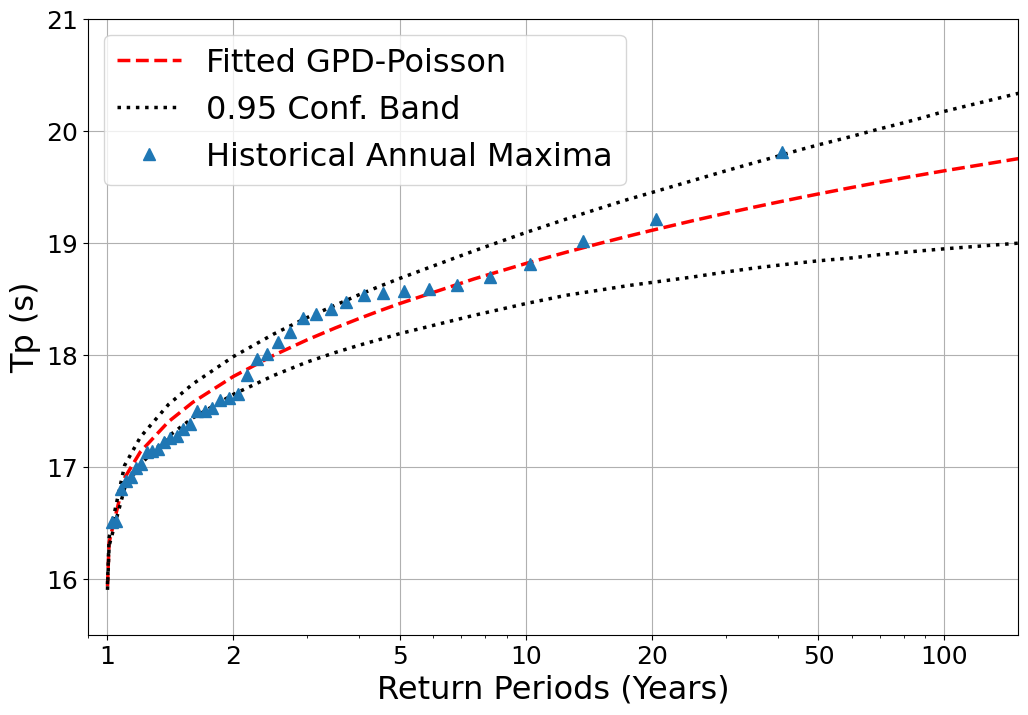

In [67]:
extr_corr_complete_tp.apply_correction(fit_diag=True)
fig, ax = extr_corr_complete_tp.return_period_plot()
ax.set_ylim(15.5, 21)
ax.set_xlim(0.9,150)
ax.set_ylabel("Tp (s)", fontsize=23)
ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.legend(loc = "upper left", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_Historical_ReturnPeriod_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [68]:
extr_corr_complete_tp.test_dist()

{'Statistic': 32.35424224420796, 'P-value': 2.5030434391837275e-09}

In [69]:
# from src.gev_utils import q_gev
from scipy.stats import genextreme
from scipy import stats

Bootstrap_test = 2000
# Historical parameters estimated
u, sigma, xi = extr_corr_complete_tp.parameters
mu = u + sigma/xi * (extr_corr_complete_tp.poiss_parameter ** xi - 1)
psi = sigma * extr_corr_complete_tp.poiss_parameter ** xi


CvM_statistic = 1/(12*extr_corr_complete_tp.n_sim_year_peaks) + np.sum((np.sort(genextreme.cdf(extr_corr_complete_tp.sim_max_data, c=-xi, loc=mu, scale=psi)) - (2*np.arange(1, extr_corr_complete_tp.n_sim_year_peaks +1) - 1)/(2*extr_corr_complete_tp.n_sim_year_peaks))**2)



# Bootstrap calibration
boot_statistic = np.zeros(Bootstrap_test)

for b in range(Bootstrap_test):
    # 1. Simulate AM of size n_hist from GEV with historical parameters
    uniform_random_hist = np.random.uniform(size=extr_corr_complete_tp.n_year_peaks)
    simulated_am_boot_hist = q_gev(uniform_random_hist, [mu, psi, xi])

    # 2. Fit GEV to simulated AM
    xi_bootfit, mu_bootfit, psi_bootfit = genextreme.fit(simulated_am_boot_hist) # Note xi_bootfit is -xi

    # 3. Simulate AM of size n_sim from GEV with historical parameters
    uniform_random_sim = np.random.uniform(size=extr_corr_complete_tp.n_sim_year_peaks)
    simulated_am_boot_sim = genextreme.ppf(uniform_random_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 4. Compute bootstrap synthetic AM values using the bootfit
    u_bootfit = genextreme.cdf(simulated_am_boot_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 5. Compute CvM test for the bootstrap sample
    boot_statistic[b] = 1/(12*extr_corr_complete_tp.n_sim_year_peaks) + np.sum((np.sort(u_bootfit) - (2*np.arange(1, extr_corr_complete_tp.n_sim_year_peaks + 1) - 1)/(2*extr_corr_complete_tp.n_sim_year_peaks))**2)

bootstrap_p_value = (1 + np.sum(boot_statistic >= CvM_statistic)) / (1 + Bootstrap_test)
print(f"Bootstrap p-value of CvM test {bootstrap_p_value}")

Bootstrap p-value of CvM test 0.0004997501249375312


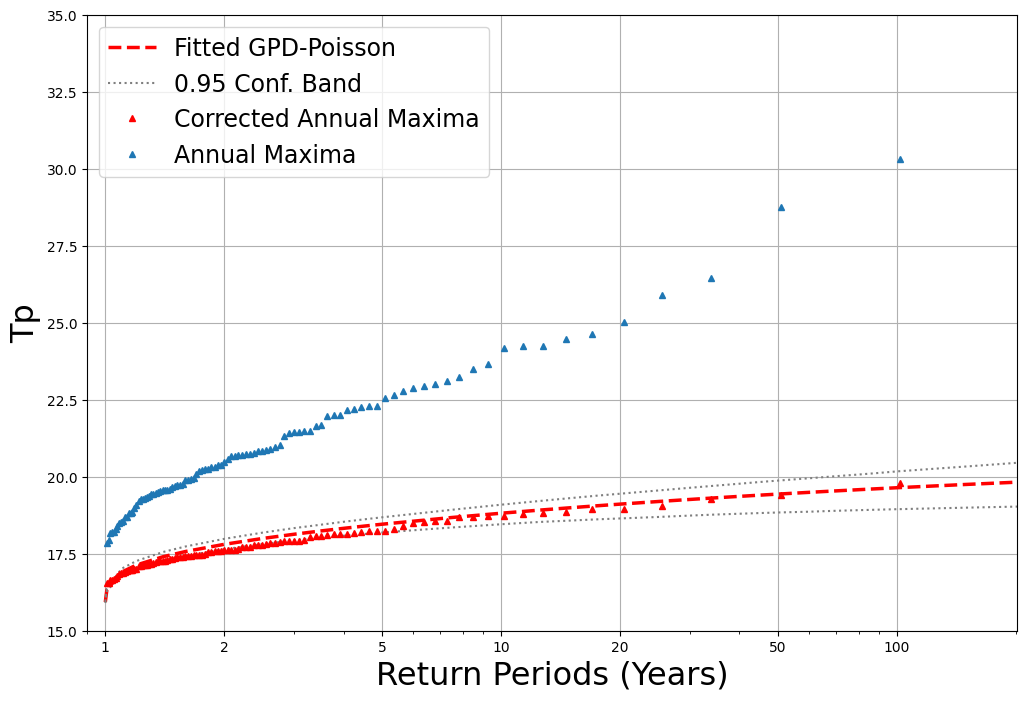

In [70]:
extr_corr_complete_tp.apply_sim_correction()
fig, ax = extr_corr_complete_tp.sim_return_period_plot(show_corrected=True, show_uncorrected=True)
# extr_corr_complete_tp.sim_return_period_plot(show_corrected=True, show_uncorrected=False)
# extr_corr_complete_tp.sim_return_period_plot(show_corrected=False, show_uncorrected=True)

ax.set_ylim(15, 35)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_Simulation_ReturnPeriod_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

In [71]:
extr_corr_complete_tp.parameters

[16.08078956604004, 0.9865893559228269, -0.19947040645308553]

In [72]:
extr_corr_complete_tp.poiss_parameter, extr_corr_complete_tp.sim_poiss_parameter

(5.95, 13.584250474383301)

In [73]:
extr_corr_complete_tp.sim_poiss_parameter/ extr_corr_complete_tp.poiss_parameter

2.283067306619042

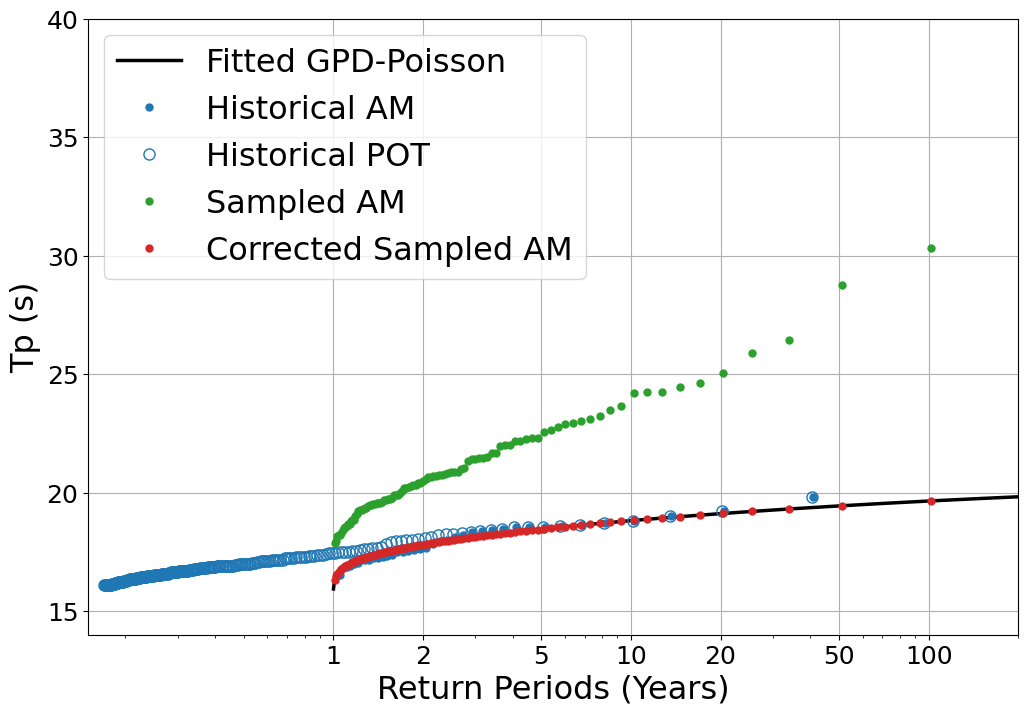

In [261]:

### Plot
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# # Fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, np.sort(extr_corr_complete_tp.x_vals_gpd_poiss_hist), color = 'black', linewidth=2.5, label='Fitted GPD-Poisson')
# # Confidence interval for fitted GPD-Poisson
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "tab:gray",linestyle='dotted', label=f'{extr_corr_complete.conf} Conf. Band')
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "tab:gray",linestyle='dotted')



# Historical data
ax.semilogx(extr_corr_complete_tp.T_annmax, extr_corr_complete_tp.max_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=5, label='Historical AM')
# T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.poiss_parameter)
T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete_tp.n_pot + 1) / (extr_corr_complete_tp.n_pot + 1))) / (extr_corr_complete_tp.n_pot / (extr_corr_complete_tp.n_pit / 362.242))
ax.semilogx(T_hist_pot, np.sort(extr_corr_complete_tp.pot_data), color="tab:blue", linewidth=0, marker='o',markersize=8, fillstyle='none', label='Historical POT')



# No corrected data
# ax.semilogx(T_pt_corrected_sim, self.sim_pit_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Daily Data')
# ax.semilogx(T_pot_sim, self.sim_pot_data_sorted, color="orange", linewidth=0, marker='o',markersize=5, label='POT')
# ax.semilogx(T_pot, extr_corr_complete.sim_pot_data_sorted, label="Sampled POT", color="tab:green", linewidth=0, marker='o',markersize=5)
ax.semilogx(extr_corr_complete_tp.T_annmax_sim, extr_corr_complete_tp.sim_max_data_sorted[extr_corr_complete_tp.am_index_0:], color="tab:green", linewidth=0, marker='o',markersize=5, label='Sampled AM')



ecdf_pot = np.arange(1, extr_corr_complete_tp.n_pot_sim + 1) / (extr_corr_complete_tp.n_pot_sim + 1)
T_pot = 1 / (1-ecdf_pot) / extr_corr_complete_tp.poiss_parameter
# Corrected data 
    # ax.semilogx(T_pt_corrected_sim, np.sort(self.sim_pit_data_corrected), linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Corrected Daily Data')
    # ax.semilogx(T_ev_corrected_sim, stats.genpareto.ppf(self.runif_pot_probs_sim, self.parameters[2], loc=self.parameters[0], scale=self.parameters[1]), 
    #             color = 'orange',linewidth=0, marker='o',markersize=5, label=f'Corrected POT')
    # ax.semilogx(self.T_annmax_sim, q_pot(self.ecdf_annmax_probs_sim, self.opt_threshold, self.poiss_parameter, self.gpd_parameters[1], self.gpd_parameters[2]), color = 'red',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
# ax.semilogx(T_pot, np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_pot_data_locs]), label="Corrected Sampled POT", color="tab:red", linewidth=0, marker='o',markersize=5)
# ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_corrected_sorted[extr_corr_complete.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')

from src.pot_utils import q_pot

sim_max_data_corrected = np.zeros(extr_corr_complete_tp.n_sim_year_peaks)
ecdf_max_probs_sim = np.arange(1, extr_corr_complete_tp.n_sim_year_peaks + 1) / (extr_corr_complete_tp.n_sim_year_peaks + 1)   # ECDF
sim_max_data_corrected[extr_corr_complete_tp.am_index_0:] = q_pot(ecdf_max_probs_sim[extr_corr_complete_tp.am_index_0:], extr_corr_complete_tp.parameters, extr_corr_complete_tp.poiss_parameter)    # Corrected POT
if extr_corr_complete_tp.n_sim_year_peaks > 1:
    sim_aux_pit_corrected = np.interp(
                    extr_corr_complete_tp.sim_pit_data,              # x-coords to interpolate
                    np.append(min(extr_corr_complete_tp.sim_pit_data), extr_corr_complete_tp.sim_max_data_sorted),    # x-coords of data points
                    np.append(min(extr_corr_complete_tp.sim_pit_data), sim_max_data_corrected)  # y-coords of data points 
                )
    sim_pit_data_corrected = sim_aux_pit_corrected
    sim_max_data_corrected_sorted = np.sort(sim_max_data_corrected)

ax.semilogx(extr_corr_complete_tp.T_annmax_sim, sim_max_data_corrected_sorted[extr_corr_complete_tp.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')



ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete_tp.var} (s)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())   
# ax.set_xlim(right=10000)
ax.set_xlim(left=0.15, right=200)
# ax.set_ylim(bottom=0)
ax.set_ylim(bottom=14, top=40)
ax.legend(loc='upper left', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_HistPOTAM_Deterministic.png", dpi=300, bbox_inches="tight")

plt.show()

## Loop over correction

In [74]:
dict_maximos_corregidos_Tp = {}
dict_sim_pit_corrected_Tp = {}
for i in range(100):
    
    extr_corr_complete_tp.apply_sim_correction(random_state=i)   # Apply the correction in the simulated data
    # if i == 0:
    #     extr_corr.sim_return_period_plot(show_corrected=True, show_uncorrected=True)                        # Default to plot the corrected and no corrected data
    #     fitted_gev = extr_corr.
    
    dict_maximos_corregidos_Tp[i] = extr_corr_complete_tp.sim_max_data_corrected_sorted
    dict_sim_pit_corrected_Tp[i] = extr_corr_complete_tp.sim_pit_data_corrected

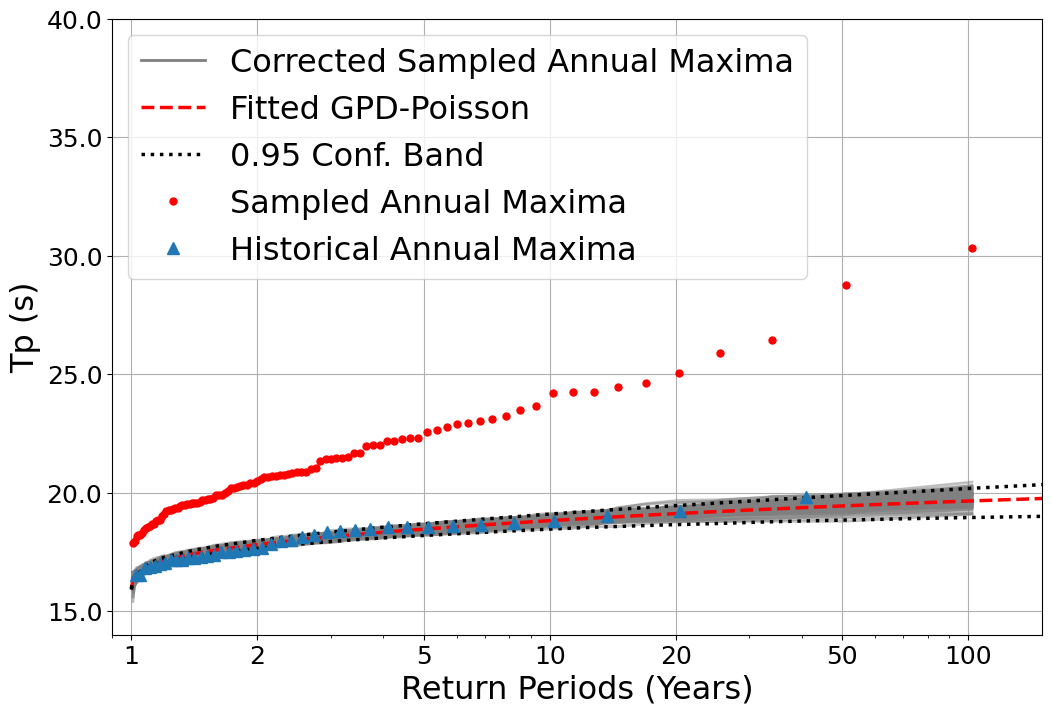

In [75]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# Corrected AM
ax.semilogx(extr_corr_complete_tp.T_annmax_sim, dict_maximos_corregidos_Tp[0], color = 'gray', linewidth=2, alpha=0.5,label='Corrected Sampled Annual Maxima')
for i in range(1,100):
    ax.semilogx(extr_corr_complete_tp.T_annmax_sim, dict_maximos_corregidos_Tp[i], color = 'gray', linewidth=2, alpha=0.5)

# Fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.x_vals_gpd_poiss_hist, color = 'red',linestyle='dashed', linewidth=2.5, label='Fitted GPD-Poisson')
# Confidence interval for fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.upper_pot_ci_return, color = "black",linestyle='dotted', linewidth=2.5, label=f'{extr_corr_complete_tp.conf} Conf. Band')
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.lower_pot_ci_return, color = "black",linestyle='dotted', linewidth=2.5)


ax.semilogx(extr_corr_complete_tp.T_annmax_sim, extr_corr_complete_tp.sim_max_data_sorted, color="red", linewidth=0, marker='o',markersize=5, label='Sampled Annual Maxima')

ax.semilogx(extr_corr_complete_tp.T_annmax, extr_corr_complete_tp.max_data_sorted, color="tab:blue", linewidth=0, marker='^',markersize=8, label='Historical Annual Maxima')

ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete_tp.var} (s)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(0.9,150)
ax.set_ylim(bottom=14, top=40)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
leg = ax.legend(loc='best', ncol=1, fontsize=23)
for lh in leg.legend_handles:
    lh.set_alpha(1)
# ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ReturnLevel_Simulated_Ensemble_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [76]:
extr_corr_complete_tp.correlation()

{'Spearman': 0.9999999999999998, 'Kendall': 1.0, 'Pearson': 0.9990681448938764}

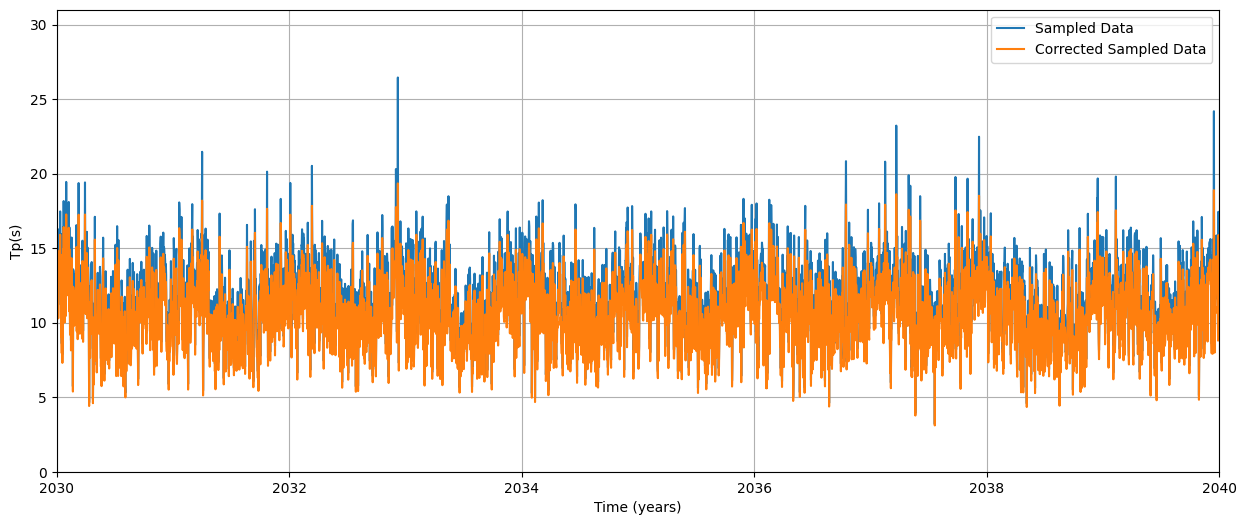

In [77]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete_tp.sim_pit_data, label="Sampled Data")
ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete_tp.sim_pit_data_corrected, label="Corrected Sampled Data")
ax.set_xlim(2030, 2040)
ax.set_ylim(0, 31)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Tp(s)")
ax.grid()
ax.legend()
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_SimTimeSeries_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Poisson parameter change between simulations

In [239]:
sim_poiss_param_100_tp = np.zeros(100)
for i in range(100):
    sim_pot_corrected_tp, _, _ = extr_corr_complete_tp.obtain_pots(
                dict_sim_pit_corrected_Tp[i],
                threshold=extr_corr_complete_tp.opt_threshold,
                n0 = extr_corr_complete_tp.pot_config['n0'],
                min_peak_distance=extr_corr_complete_tp.pot_config['min_peak_distance'],
                siglevel = extr_corr_complete_tp.pot_config['siglevel'],
                plot_flag = extr_corr_complete_tp.pot_config['plot_flag'],
                optimize_threshold=False
            )
    sim_poiss_param_100_tp[i] = sim_pot_corrected_tp.size / extr_corr_complete_tp.time_interval_sim

In [79]:
print(np.median(sim_poiss_param_100_tp), np.mean(sim_poiss_param_100_tp), np.std(sim_poiss_param_100_tp))

4.455475738682569 4.513693955001355 0.6524643142043339


In [240]:
extr_corr_complete_tp.sim_poiss_parameter

13.584250474383301

In [242]:
extr_corr_complete_tp.poiss_parameter

5.95

In [243]:
np.quantile(sim_poiss_param_100_tp, [0.025, 0.975])

array([3.5148753, 5.9713276])

In [249]:
poiss_hist, poiss_hist_lb, poiss_hist_ub = poisson_rate_ci_garwood(extr_corr_complete.n_pot, extr_corr_complete.time_interval_hist, conf=0.95)
print(f"{np.mean((sim_poiss_param_100_tp >= poiss_hist_lb) & (sim_poiss_param_100_tp <= poiss_hist_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

60.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [245]:
wald_lb = extr_corr_complete_tp.poiss_parameter - 1.96 * np.sqrt(extr_corr_complete_tp.poiss_parameter / extr_corr_complete_tp.time_interval_hist)
wald_ub = extr_corr_complete_tp.poiss_parameter + 1.96 * np.sqrt(extr_corr_complete_tp.poiss_parameter / extr_corr_complete_tp.time_interval_hist)

In [250]:
poiss_hist_lb, poiss_hist_ub

(4.168261869300696, 5.555840182046432)

In [247]:
wald_lb, wald_ub

(5.194064817593466, 6.7059351824065345)

In [248]:
print(f"{np.mean((sim_poiss_param_100_tp >= wald_lb) & (sim_poiss_param_100_tp <= wald_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

15.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [82]:
bloques = {}
for j in range(extr_corr_complete_tp.sim_max_data_sorted.size):
    if j == 0:
        bloques[j] = (
            sum((extr_corr_complete_tp.sim_pit_data >= min(extr_corr_complete_tp.sim_pit_data)) & (extr_corr_complete_tp.sim_pit_data < extr_corr_complete_tp.sim_max_data_sorted[j])), 
            (min(extr_corr_complete_tp.sim_pit_data), extr_corr_complete_tp.sim_max_data_sorted[j]), 
            (min(extr_corr_complete_tp.sim_pit_data_corrected), extr_corr_complete_tp.sim_max_data_corrected_sorted[j])
            )
    else:
        bloques[j] = (
            sum((extr_corr_complete_tp.sim_pit_data >= extr_corr_complete_tp.sim_max_data_sorted[j-1]) & (extr_corr_complete_tp.sim_pit_data < extr_corr_complete_tp.sim_max_data_sorted[j])), 
            (extr_corr_complete_tp.sim_max_data_sorted[j-1], extr_corr_complete_tp.sim_max_data_sorted[j]), 
            (extr_corr_complete_tp.sim_max_data_corrected_sorted[j-1], extr_corr_complete_tp.sim_max_data_corrected_sorted[j])
            )

In [83]:
bloques

{0: (36484,
  (2.3518926411971, 17.850811503524792),
  (2.3518926411971, 16.244174031933053)),
 1: (41,
  (17.850811503524792, 17.956235225790262),
  (16.244174031933053, 16.251936326999065)),
 2: (63,
  (17.956235225790262, 18.175428787397607),
  (16.251936326999065, 16.424018738856837)),
 3: (3,
  (18.175428787397607, 18.19710327573736),
  (16.424018738856837, 16.587873366963436)),
 4: (4,
  (18.19710327573736, 18.220296343180422),
  (16.587873366963436, 16.662971446066496)),
 5: (16,
  (18.220296343180422, 18.311216434209072),
  (16.662971446066496, 16.694041107548475)),
 6: (16,
  (18.311216434209072, 18.40768419150487),
  (16.694041107548475, 16.707204306729693)),
 7: (13,
  (18.40768419150487, 18.48547739319836),
  (16.707204306729693, 16.847938960976066)),
 8: (8,
  (18.48547739319836, 18.538906402633486),
  (16.847938960976066, 16.853921808465294)),
 9: (4,
  (18.538906402633486, 18.577365591007776),
  (16.853921808465294, 16.910939060840942)),
 10: (21,
  (18.577365591007776, 

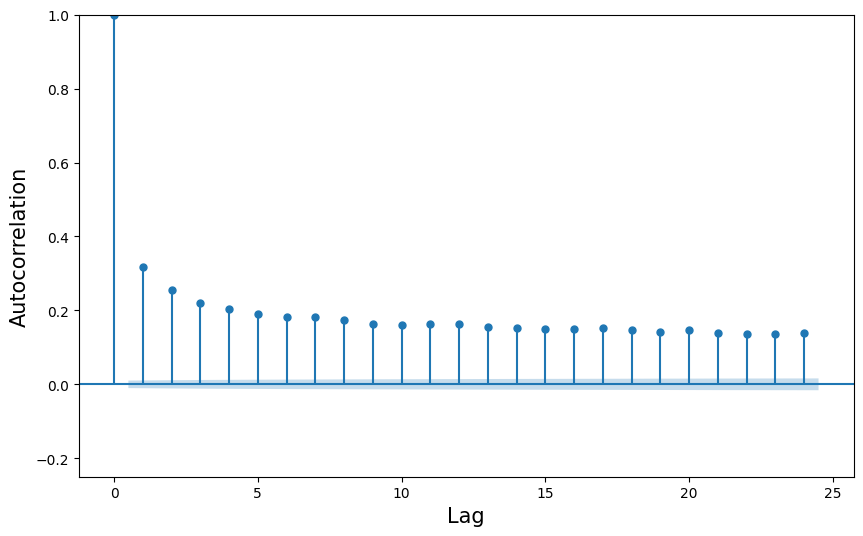

In [84]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_acf(extr_corr_complete_tp.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [85]:
acf_hist, confint_hist = acf(extr_corr_complete_tp.sim_pit_data, nlags=7, alpha=0.05)
acf_sim, confint_sim = acf(extr_corr_complete_tp.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [86]:
stats.pearsonr(acf_hist, acf_sim)

PearsonRResult(statistic=0.9999974208925158, pvalue=4.288915538623323e-17)

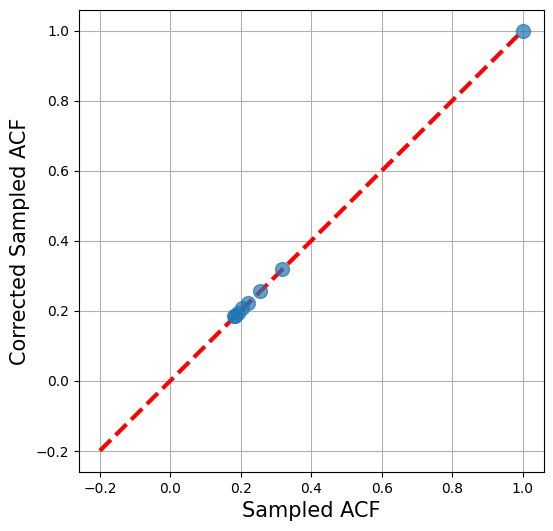

In [87]:
plt.figure(figsize=(6,6))
plt.plot([-0.2,1],[-0.2,1], 'r--', linewidth=3)
plt.plot(acf_hist, acf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled ACF", fontsize=15)
plt.ylabel("Corrected Sampled ACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

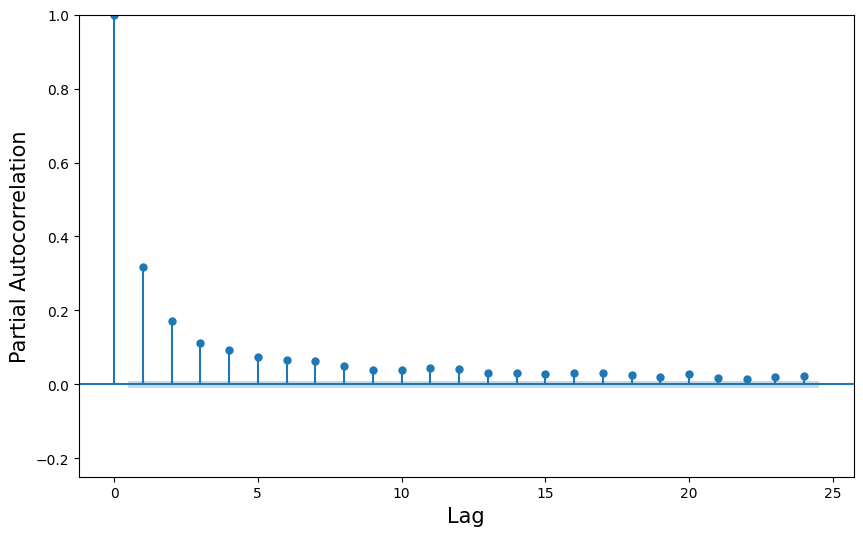

In [88]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_pacf(extr_corr_complete_tp.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Partial Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_PACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [89]:
pacf_hist, pconfint_hist = pacf(extr_corr_complete_tp.sim_pit_data, nlags=7, alpha=0.05)
pacf_sim, pconfint_sim = pacf(extr_corr_complete_tp.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [90]:
stats.pearsonr(pacf_hist, pacf_sim)

PearsonRResult(statistic=0.9999948004763883, pvalue=3.5142202687207947e-16)

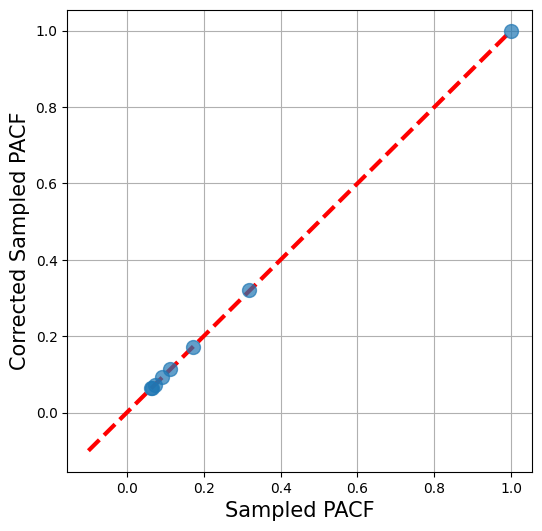

In [91]:
plt.figure(figsize=(6,6))
plt.plot([-0.1,1],[-0.1,1], 'r--', linewidth=3)
plt.plot(pacf_hist, pacf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled PACF", fontsize=15)
plt.ylabel("Corrected Sampled PACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_PACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

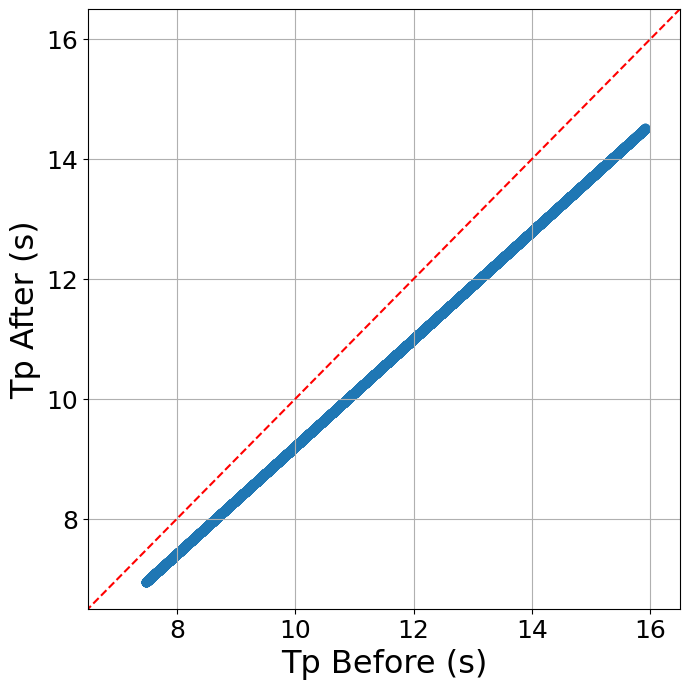

In [264]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
# QQ plot (top) before
probabilities_qq = (np.arange(1, extr_corr_complete_tp.n_sim_pit + 1)) / (extr_corr_complete_tp.n_sim_pit+1)
mask_probs = (probabilities_qq >= 0.05) & (probabilities_qq <= 0.95)

ax1.scatter(extr_corr_complete_tp.sim_pit_data_sorted[mask_probs], np.sort(extr_corr_complete_tp.sim_pit_data_corrected)[mask_probs], label="Data vs GPD", alpha=0.7)
ax1.plot([0,20], [0,20], 'r--', label="y = x (Reference)")
ax1.set_xlabel("Tp Before (s)", fontsize=23)
ax1.set_ylabel("Tp After (s)", fontsize=23)
ax1.grid()
ax1.set_xlim(6.5, 16.5)
ax1.set_ylim(6.5, 16.5)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.savefig(f"{extr_corr_complete_tp.folder}/Tp_BeforeAfterCorr.png", dpi=300, bbox_inches='tight')
# plt.close(fig)

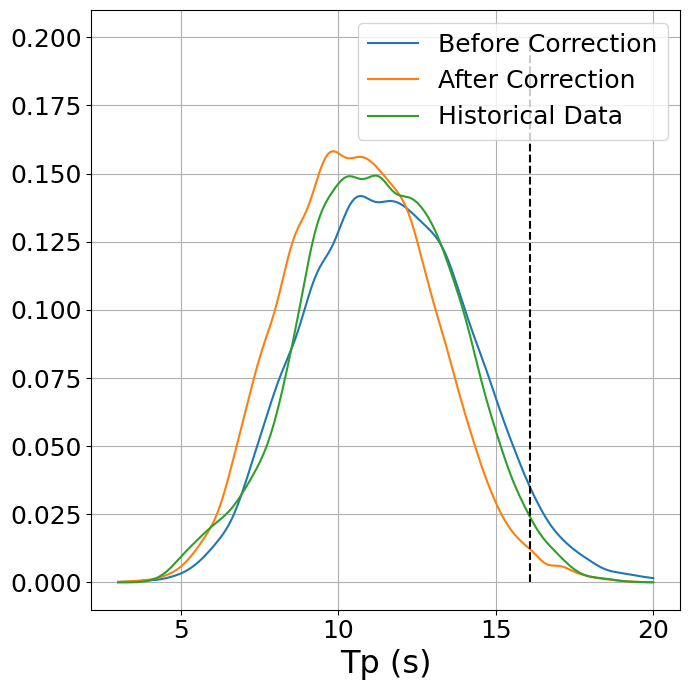

In [301]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

density_before = gaussian_kde(extr_corr_complete_tp.sim_pit_data)
density_after = gaussian_kde(extr_corr_complete_tp.sim_pit_data_corrected)
density_hist = gaussian_kde(df_hist["Tp"])

x_vals = np.linspace(3, 20, 200)
ax1.plot(x_vals, density_before(x_vals), label="Before Correction", color="tab:blue")
ax1.plot(x_vals, density_after(x_vals), label="After Correction", color="tab:orange")
ax1.plot(x_vals, density_hist(x_vals), label="Historical Data", color="tab:green")
ax1.set_xlabel("Tp (s)", fontsize=23)

# ax1.hist(extr_corr_complete.sim_pit_data, bins=50, alpha=0.5, density=True, label="Before Correction")
# ax1.hist(extr_corr_complete.sim_pit_data_corrected, bins=50, alpha=0.5, density=True, label="After Correction")
# ax1.hist(df_hist["Hs"], bins=50, alpha=0.5, density=True, label="Historical Data")
# ax1.scatter(extr_corr_complete.sim_pit_data_sorted, np.sort(extr_corr_complete.sim_pit_data_corrected)[mask_probs], label="Data vs GPD", alpha=0.7)
# ax1.plot([0,5], [0,5], 'r--', label="y = x (Reference)")
# ax1.set_xlabel("Hs Before (m)", fontsize=23)
# ax1.set_ylabel("Hs After (m)", fontsize=23)
ax1.grid()
# ax1.set_xlim(0.8, 5)
# ax1.set_ylim(0.8, 5)

ax1.legend(fontsize=18)

ax1.vlines(extr_corr_complete_tp.opt_threshold, 0,0.2, color="black", linestyle="--", label="Optimal Threshold")

# ax1.set_xlim(extr_corr_complete_tp.opt_threshold -1, 20)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
# plt.savefig(f"{extr_corr_complete.folder}/Hs_BeforeAfterCorr.png", dpi=300, bbox_inches='tight')
# plt.close(fig)

# Correlation between series

In [93]:
spear_corr_before= stats.spearmanr(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
spear_corr_after = stats.spearmanr(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]
kendall_corr_before= stats.kendalltau(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
kendall_corr_after= stats.kendalltau(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]
pearson_corr_before= stats.pearsonr(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
pearson_corr_after= stats.pearsonr(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]

print(f"Spearman {spear_corr_before} -> {spear_corr_after}")
print(f"Kendall {kendall_corr_before} -> {kendall_corr_after}")
print(f"Pearson {pearson_corr_before} -> {pearson_corr_after}")

Spearman 0.531681781803654 -> 0.531681781803654
Kendall 0.3707662987350247 -> 0.3707662987350247
Pearson 0.5066222650234152 -> 0.5213893396298681


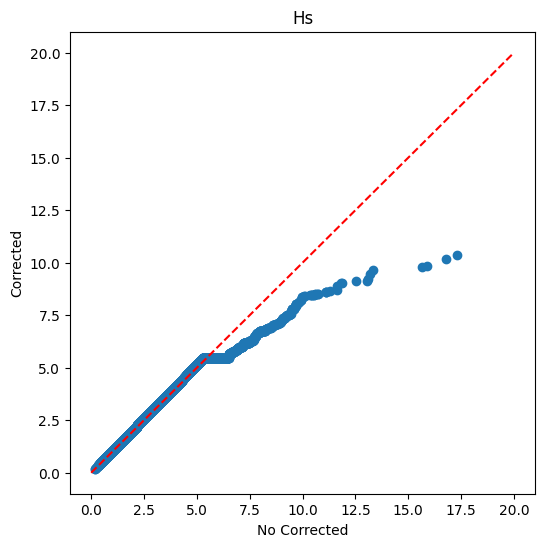

In [94]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(extr_corr_complete.sim_pit_data, extr_corr_complete.sim_pit_data_corrected)

ax.plot([0, 20], [0,20], "--r")
ax.set_title("Hs")
ax.set_xlabel("No Corrected")
ax.set_ylabel("Corrected")
plt.show()


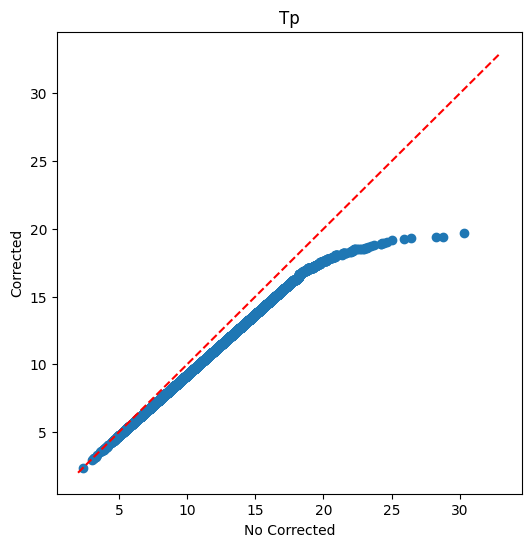

In [95]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(extr_corr_complete_tp.sim_pit_data, extr_corr_complete_tp.sim_pit_data_corrected)

ax.plot([2, 33], [2,33], "--r")
ax.set_title("Tp")
ax.set_xlabel("No Corrected")
ax.set_ylabel("Corrected")
plt.show()


Bivariate comparative

$$ 
\hat{\chi}(u)=\frac{\#\lbrace i: \hat{U}_i > u, \hat{V}_i > u \rbrace}{\#\lbrace i: \hat{U}_i > u\rbrace}, \quad u\in\lbrace 0.95, 0.97, 0.99\rbrace
$$

In [96]:
from statsmodels.distributions.empirical_distribution import ECDF

In [97]:
unified_threshold = 0.99

ecdf_hs_before = ECDF(extr_corr_complete.sim_pit_data)
ecdf_hs_after = ECDF(extr_corr_complete.sim_pit_data_corrected)

ecdf_tp_before = ECDF(extr_corr_complete_tp.sim_pit_data)
ecdf_tp_after = ECDF(extr_corr_complete_tp.sim_pit_data_corrected)

xi_before = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold)) / np.sum(ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold)

xi_after = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold)) / np.sum(ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold)
xi_before, xi_after

(0.0921409214092141, 0.0921409214092141)

$$
\hat{C}(u,u) = \frac{1}{n}\sum_{i=1}^{n}\textbf{1}\lbrace \hat{U}_i \leq u, \hat{V}_i \leq u\rbrace, \quad \hat{\theta}(u) = \frac{\log{(\hat{C}(u,u))}}{\log{(u)}}.
$$

In [98]:
c_uu_before = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) <= unified_threshold) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) <= unified_threshold)) / extr_corr_complete.n_sim_pit
theta_before = np.log(c_uu_before) / np.log(unified_threshold)

c_uu_after = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) <= unified_threshold) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) <= unified_threshold)) / extr_corr_complete.n_sim_pit
theta_after = np.log(c_uu_after) / np.log(unified_threshold)

theta_before, theta_after

(1.9171705495758768, 1.9171705495758768)